### **CHANGE DETECTION**
#### ***Step 1 : SET UP PATH***

* dir_image_T1 : Path to the folder containing images at time T1

* dir_image_T2 : Path to the folder containing images at time T2

*  model_path : Path to the pretrain weights



In [13]:
model_path= r'/home/skymap/data/Bahrain_change/w_tot_nhat_9_8/u2net_new_vege_1314_62_model.h5'

dir_image_T1= r"/home/skymap/data/Bahrain_change/Improve_model/test_step/T1/t1_cut/tmp/T1_cut_img"
dir_image_T2 = r'/home/skymap/data/Bahrain_change/Improve_model/test_step/T2/t2_cut/tmp/T2_cut_img'
dir_out = r"/home/skymap/data/Bahrain_change/Improve_model/test_step/mask"


#### ***Step 2 : Run code***
* Run the code to import the library and necessary functions 


In [14]:
import numpy as np
import rasterio
import argparse
from rasterio.windows import Window
import threading
from tqdm import tqdm
import concurrent.futures
import warnings, cv2, os
import tensorflow as tf
# import Vectorization
from skimage.morphology import skeletonize, remove_small_holes, remove_small_objects
from rio_tiler.io import COGReader
from tensorflow.compat.v1.keras.backend import set_session
warnings.filterwarnings("ignore")
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.compat.v1.Session(config=config))
import glob
def get_quantile_schema(img):
    qt_scheme = []
    try:
        with COGReader(img) as cog:
            stats = cog.stats()
            for _, value in stats.items():
                qt_scheme.append({
                    'p2': value['percentiles'][0],
                    'p98': value['percentiles'][1],
                })
    except:
        with COGReader(img) as cog:
            stats = cog.statistics()
            for _, value in stats.items():
                qt_scheme.append({
                    'p2': value['percentile_2'],
                    'p98': value['percentile_98'],
                })
    with rasterio.open(img) as r:
        num_band = r.count
        for chanel in range(1,num_band+1):
            data = r.read(chanel).astype(np.float16)
            data[data==0] = np.nan
            qt_scheme.append({
                'p2': np.nanpercentile(data, 2),
                'p98': np.nanpercentile(data, 98),
            })
    return qt_scheme
def get_quantile_schema(img):
    qt_scheme = []
    with COGReader(img) as cog:
        stats = cog.stats()
        for _, value in stats.items():
            qt_scheme.append({
                'p2': value['percentile_2'],
                'p98': value['percentile_98'],
            })
    return qt_scheme
def batch_split(iterable, n=1):

    new_list = []
    l = len(iterable)
    for ndx in range(0, l, n):
        new_list.append(iterable[ndx:min(ndx + n, l)])
    return new_list


def predict_farm(model, path_image1,path_image2, path_predict, cfd, num_bands, size=512):
  
    batch_size = 8
    with rasterio.open(path_image1) as raster1:
        with rasterio.open(path_image2) as raster2:
            meta = raster1.meta
            meta.update({'count': 1, 'nodata': 0, "dtype": "uint8"})
            height, width = raster1.height, raster1.width
            input_size = size
            stride_size = input_size - input_size // 4
            padding = int((input_size - stride_size) / 2)

            list_coordinates = []
            for start_y in range(0, height, stride_size):
                for start_x in range(0, width, stride_size):
                    x_off = start_x if start_x == 0 else start_x - padding
                    y_off = start_y if start_y == 0 else start_y - padding

                    end_x = min(start_x + stride_size + padding, width)
                    end_y = min(start_y + stride_size + padding, height)

                    x_count = end_x - x_off
                    y_count = end_y - y_off
                    list_coordinates.append(tuple([x_off, y_off, x_count, y_count, start_x, start_y]))
            with rasterio.open(path_predict, 'w+', **meta, compress='lzw') as r:
                read_lock = threading.Lock()
                write_lock = threading.Lock()

                def process(coordinates):
                    list_image_detect = []
                    list_mask = []
                    list_shape = []
                    with read_lock:
                        for coord in coordinates:
                            x_off, y_off, x_count, y_count, start_x, start_y = coord
                            read_wd = Window(x_off, y_off, x_count, y_count)
                     
                            values1 = raster1.read(window=read_wd)[0: num_bands]
                            values2 = raster2.read(window=read_wd)[0: num_bands]
                            if raster1.profile["dtype"] == "uint8" and raster2.profile["dtype"] == "uint8":
                                image_detect1 = values1.transpose(1, 2, 0).astype(int)
                                image_detect2 = values2.transpose(1, 2, 0).astype(int)

                            if image_detect1.shape != image_detect2.shape:
                                diff_rows = int(abs(image_detect1.shape[0] - image_detect2.shape[0]))
                                diff_cols = int(abs(image_detect1.shape[1] - image_detect2.shape[1]))

                                if image_detect1.shape[0] > image_detect2.shape[0]:
                                    padded_arr1 = np.zeros((image_detect1.shape[0], image_detect1.shape[1], image_detect1.shape[2]))
                                    for i in range(num_bands):
                                        padded_arr1[:, :, i] = np.pad(image_detect2[:, :, i], ((0, diff_rows), (0, diff_cols)), mode='constant', constant_values=0)
                                    image_detect = np.zeros((image_detect1.shape[0], image_detect1.shape[1], num_bands*2))
                                    image_detect[:, :, 0: num_bands] = image_detect1[:, :, 0: num_bands]
                                    image_detect[:, :, num_bands: num_bands * 2] = padded_arr1[:, :, 0: num_bands]

                                if image_detect1.shape[0] < image_detect2.shape[0]:
                                    padded_arr1 = np.zeros((image_detect2.shape[0], image_detect2.shape[1], image_detect2.shape[2]))
                                    for i in range(num_bands):
                                        padded_arr1[:, :, i] = np.pad(image_detect2[:, :, i], ((0, diff_rows), (0, diff_cols)), mode='constant', constant_values=0)
                                    image_detect = np.zeros((image_detect2.shape[0], image_detect2.shape[1], num_bands*2))
                                    image_detect[:, :, 0: num_bands] = padded_arr1[:, :, 0: num_bands]
                                    image_detect[:, :, num_bands: num_bands * 2] = image_detect2[:, :, 0: num_bands]

                                if image_detect1.shape[1] > image_detect2.shape[1]:
                                    padded_arr1 = np.zeros((image_detect1.shape[0], image_detect1.shape[1], image_detect1.shape[2]))
                                    for i in range(num_bands):
                                        padded_arr1[:, :, i] = np.pad(image_detect2[:, :, i], ((0, diff_rows), (0, diff_cols)), mode='constant', constant_values=0)
                                    image_detect = np.zeros((image_detect1.shape[0], image_detect1.shape[1], num_bands * 2))
                                    image_detect[:, :, 0: num_bands] = image_detect1[:, :, 0: num_bands]
                                    image_detect[:, :, num_bands: num_bands*2] = padded_arr1[:, :, 0: num_bands]

                                if image_detect1.shape[1] < image_detect2.shape[1]:
                                    padded_arr1 = np.zeros((image_detect2.shape[0], image_detect2.shape[1], image_detect2.shape[2]))
                                    for i in range(num_bands):
                                        padded_arr1[:, :, i] = np.pad(image_detect2[:, :, i], ((0, diff_rows), (0, diff_cols)), mode='constant', constant_values=0)
                                    image_detect = np.zeros((image_detect2.shape[0], image_detect2.shape[1], num_bands*2))
                                    image_detect[:, :, 0: num_bands] = padded_arr1[:, :, 0: num_bands]
                                    image_detect[:, :, num_bands: num_bands*2] = image_detect2[:, :, 0: num_bands]
                            else:
                                image_detect = np.zeros((image_detect1.shape[0], image_detect1.shape[1], num_bands*2))
                                image_detect[:, :, 0: num_bands] = image_detect1[:, :, 0: num_bands]
                                image_detect[:, :, num_bands: num_bands*2] = image_detect2[:, :, 0: num_bands]

                            img_temp = np.zeros((input_size, input_size, image_detect.shape[2]))
                            mask = np.pad(np.ones((stride_size, stride_size), dtype=np.uint8), ((padding, padding), (padding, padding)))
                            shape = (stride_size, stride_size)

                            if y_count < input_size or x_count < input_size:
                                img_temp = np.zeros((input_size, input_size, image_detect.shape[2]))
                                mask = np.zeros((input_size, input_size), dtype=np.uint8)
                                if start_x == 0 and start_y == 0:
                                    img_temp[(input_size - y_count): input_size, (input_size - x_count): input_size] = image_detect
                                    mask[(input_size - y_count): input_size - padding, (input_size - x_count): input_size-padding] = 1
                                    shape = (y_count - padding, x_count - padding)
                                elif start_x == 0:
                                    img_temp[0: y_count, (input_size - x_count): input_size] = image_detect
                                    if y_count == input_size:
                                        mask[padding: y_count - padding, (input_size - x_count): input_size - padding] = 1
                                        shape = (y_count - 2 * padding, x_count - padding)
                                    else:
                                        mask[padding: y_count, (input_size - x_count): input_size - padding] = 1
                                        shape = (y_count - padding, x_count - padding)
                                elif start_y == 0:
                                    img_temp[(input_size - y_count): input_size, 0: x_count] = image_detect
                                    if x_count == input_size:
                                        mask[(input_size - y_count):input_size-padding, padding:x_count-padding] = 1
                                        shape = (y_count - padding, x_count - 2 * padding)
                                    else:
                                        mask[(input_size - y_count): input_size - padding, padding: x_count] = 1
                                        shape = (y_count - padding, x_count - padding)
                                else:
                                    img_temp[0: y_count, 0: x_count] = image_detect
                                    mask[padding: y_count, padding: x_count] = 1
                                    shape = (y_count - padding, x_count - padding)

                                image_detect = img_temp

                            mask = (mask != 0)
                            list_image_detect.append(cv2.resize(image_detect.astype(np.uint8), (size,size), interpolation = cv2.INTER_AREA))
                            list_mask.append(mask)
                            list_shape.append(shape)
                        numpy_list_image_detect = np.array(list_image_detect)
                        if np.count_nonzero(numpy_list_image_detect) > 0:
                            if len(np.unique(numpy_list_image_detect)) <= 2:
                                pass
                            else:
                                # resized = cv2.resize(image_detect.astype(np.uint8), (256,256), interpolation = cv2.INTER_AREA)
                                y_pred = model.predict(numpy_list_image_detect/255)
                                y_pred = np.array(y_pred).transpose(1,0,2,3,4)
                            # print(y_pred.shape)
                                with write_lock:
                                    for i in range(len(coordinates)):
                                        x_off, y_off, x_count, y_count, start_x, start_y = coordinates[i]
                                        

                                        y_pred0 = y_pred[i]
                                        y_pred0 = (y_pred0[0,...,0] > cfd).astype(np.uint8)
                                        mask0= list_mask[i]
                                        shape0 = list_shape[i]
                        
                                        y_pred0 = (cv2.resize(y_pred0, (size,size), interpolation = cv2.INTER_AREA)>0.5).astype(np.uint8)
                                        y = y_pred0[mask0].reshape(shape0)

                                        
                                        r.write(y[np.newaxis,...], window=Window(start_x, start_y, shape0[1], shape0[0]))

                chunks = batch_split(list_coordinates,n=batch_size)
                # print(chunks[884:])
                for coordsss in tqdm(chunks):
                    # print(coordsss)
                    process(coordsss)
    
def Morphology(image):
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    # dilation  
    # img = cv2.dilate(data,kernel,iterations = 1)
    # opening
    #     img = cv2.morphologyEx(data, cv2.MORPH_OPEN, kernel)
    # for i in range(10):
    #     img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

    # img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel2)
    # closing
    #     for _ in range(2):
    img = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel2)
    return img

from skimage.morphology import skeletonize
def raster_to_vector(path_in, path_out, threshold_distance, threshold_connect):
    print('start convert raster to vector ...')
    with rasterio.open(path_in) as inds:
        data = inds.read()[0]
        transform = inds.transform
        projstr = inds.crs.to_string()
        
    data = Morphology(data)
    data = remove_small_holes(data.astype(bool), area_threshold=77)
    data = remove_small_objects(data, min_size=77)
    skeleton = skeletonize(data.astype(np.uint8))

list_img1 = glob.glob(os.path.join(dir_image_T1, '*.tif'))
list_img2 = glob.glob(os.path.join(dir_image_T2, '*.tif'))
list_img1.sort()
list_img2.sort()
os.makedirs(dir_out, exist_ok=True)
threshold_distance = 3 
threshold_connect = 3
count = 0

2023-11-08 00:21:05.516222: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10265 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:05:00.0, compute capability: 7.5


#### ***Step 3 : Load model and predict***
##### Set model parameters
* size : size of model 
* confidence : confidence for predict
* num_bands : the number of bands of the input image


In [15]:

size = 512
confidence  = 0.4
num_bands = 4
model_predict = tf.keras.models.load_model(model_path)
model_predict.trainable = False


##### Predict

In [16]:

print('==============================building===========================================')
for input_path1, input_path2 in zip(list_img1, list_img2):
    print('Predicting.....:', input_path1)
    print('Predicting.....:', input_path2)
    
    output_path = os.path.join(dir_out, os.path.basename(input_path1))
    predict_farm(model_predict, input_path1, input_path2, output_path, confidence ,num_bands=num_bands, size=size)
    count += 1

==============================building===========================================
dang predict anh: /home/skymap/data/Bahrain_change/Improve_model/test_step/T1/t1_cut/tmp/T1_cut_img/T14_74_0.tif
dang predict anh: /home/skymap/data/Bahrain_change/Improve_model/test_step/T2/t2_cut/tmp/T2_cut_img/T14_74_0.tif
count 0
cfd 0.4


  0%|          | 0/7 [00:00<?, ?it/s]

2023-11-08 00:21:16.712499: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
100%|██████████| 7/7 [00:33<00:00,  4.79s/it]


#### ***Step 5 : Visualize Model Output***


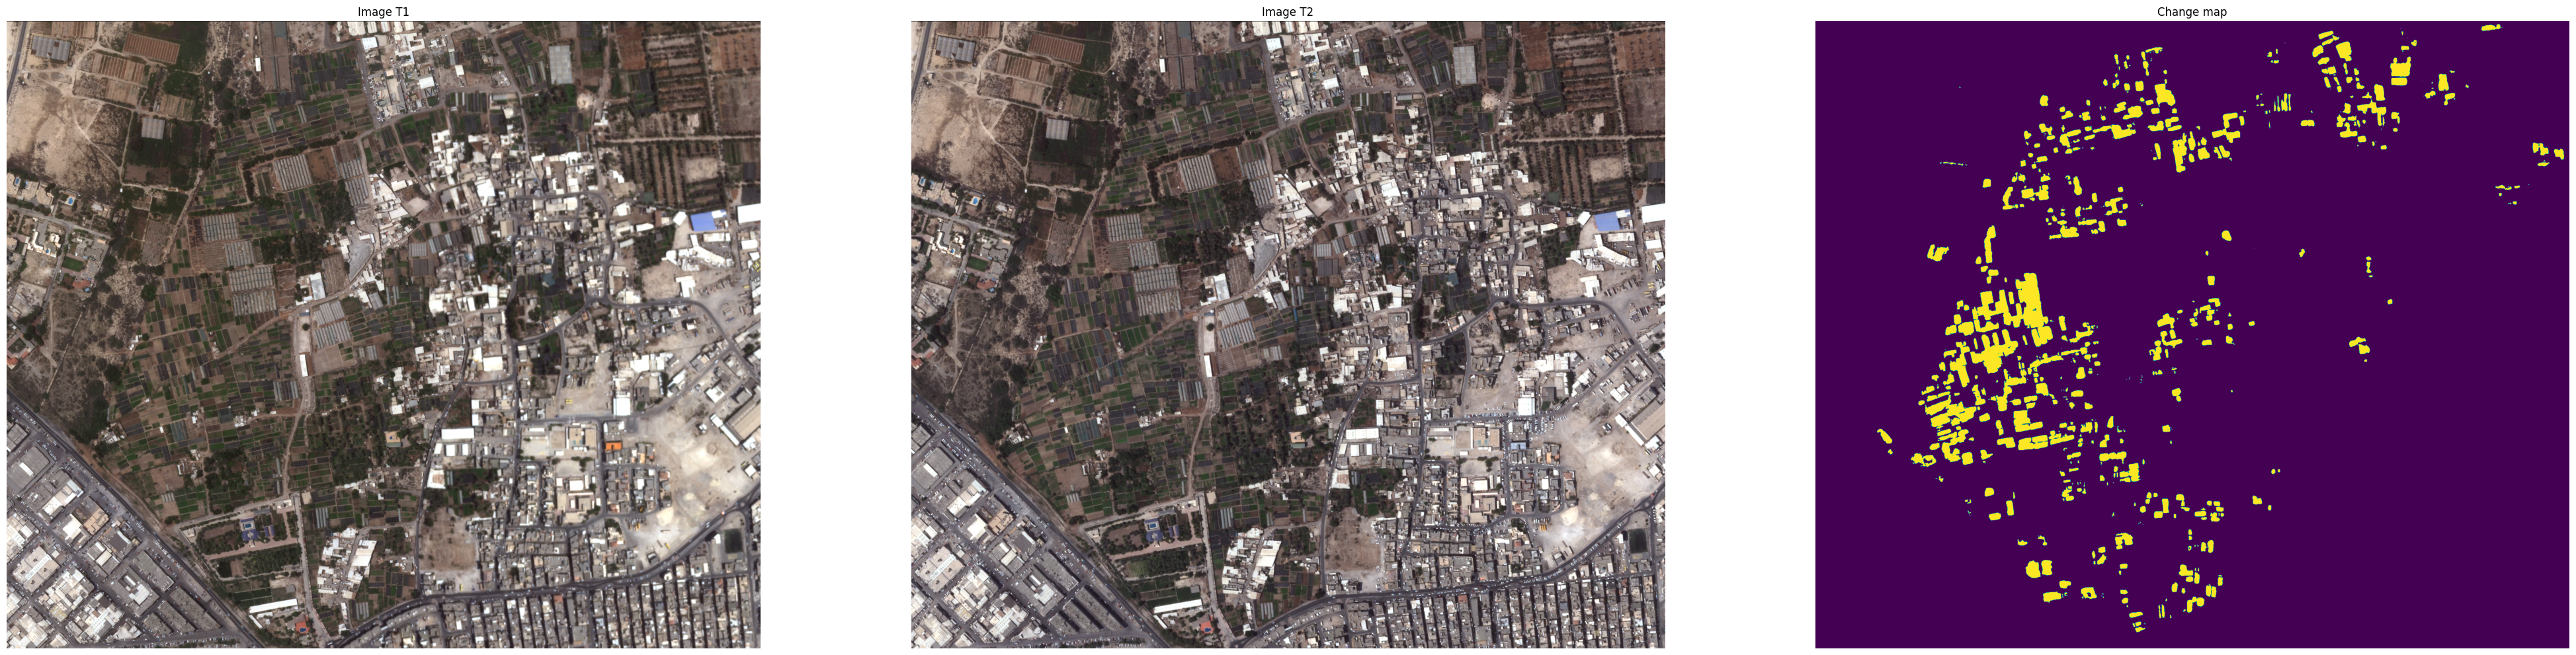

In [20]:
# Đọc 3 hình ảnh
%matplotlib inline
import matplotlib.pyplot as plt

import rasterio

for fp_mask in glob.glob(os.path.join(dir_out,'*.tif')):
    path_img1 = os.path.join(dir_image_T1, os.path.basename(fp_mask))
    path_img2 = os.path.join(dir_image_T2, os.path.basename(fp_mask))



    with rasterio.open(path_img1) as src1:
        image1 = src1.read()[0:3]
        image1 = image1.transpose(1,2,0)
    with rasterio.open(path_img2) as src2:
        image2 = src2.read()[0:3]
        image2 = image2.transpose(1,2,0)
    with rasterio.open(fp_mask) as src3:
        image3 = src3.read()
        image3 = image3.transpose(1,2,0)
    # Tạo một hình vẽ với 3 cột
    fig, axes = plt.subplots(1, 3, figsize=(50, 50))

    # Hiển thị hình ảnh trên từng cột
    axes[0].imshow(image1)
    axes[0].set_title('Image T1')

    axes[1].imshow(image2)
    axes[1].set_title('Image T2')

    axes[2].imshow(image3)
    axes[2].set_title('Change map')

    # Tắt trục
    for ax in axes:
        ax.axis('off')

    # Hiển thị các hình ảnh
    plt.show()
